In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [5]:
torch.cuda.is_available()
torch.backends.cudnn.enabled


True

In [6]:
#overcast 20191030T161529_VOOR
#partly 20191112T183029_VOOR
#clear 20190511T122529_VOOR
PATH = '/home/arnold/raindrop-detection-cnn/VOOR'
data_dir = pathlib.Path(PATH)
#resize image 
sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1316


In [7]:
roses = list(data_dir.glob('rain/*'))
# PIL.Image.open(str(roses[0]))

In [8]:
files = os.listdir(f'{PATH}/clear')[:10]
files

['20190607T131529_VOOR.jpg',
 '20190301T135030_VOOR.jpg',
 '20190607T135030_VOOR.jpg',
 '20190320T221030_VOOR.jpg',
 '20190301T164029_VOOR.jpg',
 '20190607T144030_VOOR.jpg',
 '20190320T150540_VOOR.jpg',
 '20190301T152029_VOOR.jpg',
 '20190320T124530_VOOR.jpg',
 '20190320T141530_VOOR.jpg']

(720, 1280, 3)

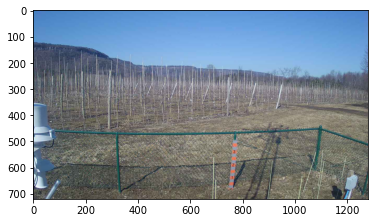

In [9]:
img = plt.imread(f'{PATH}/clear/{files[9]}')
plt.imshow(img);
img.shape
# First 4 rows and columns of the image
#img[:4,:4]

In [10]:
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [11]:
batch_size = 32
img_height = 720
img_width = 1280

In [12]:
#run rm -rf .ipynb_checkpoints to get correct class names

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1336 files belonging to 7 classes.
Using 1069 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1336 files belonging to 7 classes.
Using 267 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['clear', 'few', 'night', 'overcast', 'rain', 'scattered', 'snow']


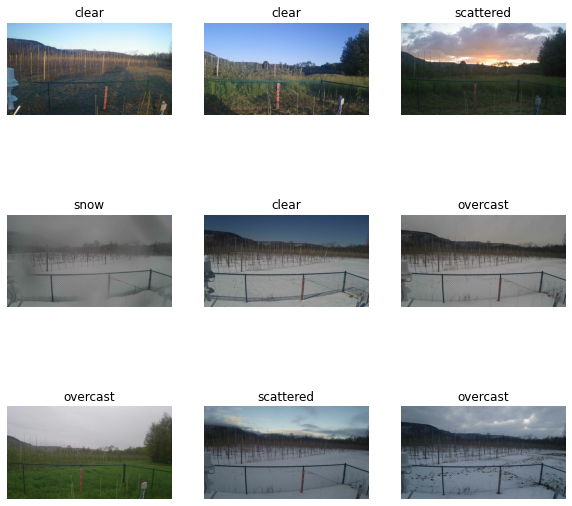

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
#tensor of shape (bathsize, hgt, width, rgb)
#call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 720, 1280, 3)
(32,)


In [18]:
#NOTE
'''
Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. 
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
#RGB channel values are in the [0, 255] range. Bad for neural network; want input values small. 
#Standardize values to be in the [0, 1] by using a Rescaling layer.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [21]:
num_classes = 7
#build the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
#compile the model (To view training and validation accuracy for each training epoch, pass the metrics argument)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
#View all the layers of the network using the model's summary method:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 720, 1280, 3)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 720, 1280, 16)     448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 360, 640, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 640, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 320, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 320, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 160, 64)       0

In [24]:
#train the model
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
34/34 [==============================] - 17s 510ms/step - loss: 5.5322 - accuracy: 0.4574 - val_loss: 0.7632 - val_accuracy: 0.7116
Epoch 2/25
34/34 [==============================] - 12s 348ms/step - loss: 0.5673 - accuracy: 0.7998 - val_loss: 0.3765 - val_accuracy: 0.8502
Epoch 3/25
34/34 [==============================] - 7s 199ms/step - loss: 0.2930 - accuracy: 0.8943 - val_loss: 0.2623 - val_accuracy: 0.9101
Epoch 4/25
34/34 [==============================] - 6s 190ms/step - loss: 0.2597 - accuracy: 0.9093 - val_loss: 0.5248 - val_accuracy: 0.7753
Epoch 5/25
34/34 [==============================] - 7s 214ms/step - loss: 0.2255 - accuracy: 0.9149 - val_loss: 0.3301 - val_accuracy: 0.8989
Epoch 6/25
34/34 [==============================] - 9s 270ms/step - loss: 0.1729 - accuracy: 0.9439 - val_loss: 0.1828 - val_accuracy: 0.9588
Epoch 7/25
34/34 [==============================] - 7s 194ms/step - loss: 0.1408 - accuracy: 0.9514 - val_loss: 0.1518 - val_accuracy: 0.9625
Epoc

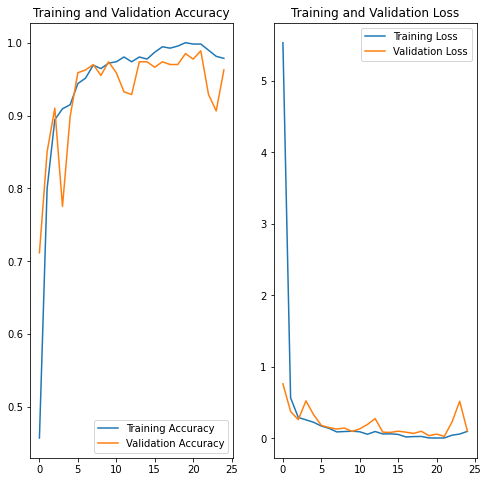

"\nNOTE\nif training accuracy and validation accuracy are off by large margin then need to tune the model and its overfitting\noverfitting if diiff in acc between training and val accuracy is noticeable\nalso if training acc inc linearly but val acc stalls around 50-60%\n\nFIX:\n'When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.\n\nThere are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.'\n"

In [26]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

'''
NOTE
if training accuracy and validation accuracy are off by large margin then need to tune the model and its overfitting
overfitting if diiff in acc between training and val accuracy is noticeable
also if training acc inc linearly but val acc stalls around 50-60%

FIX:
'When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.'
'''

In [25]:
#Data augmentation - generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

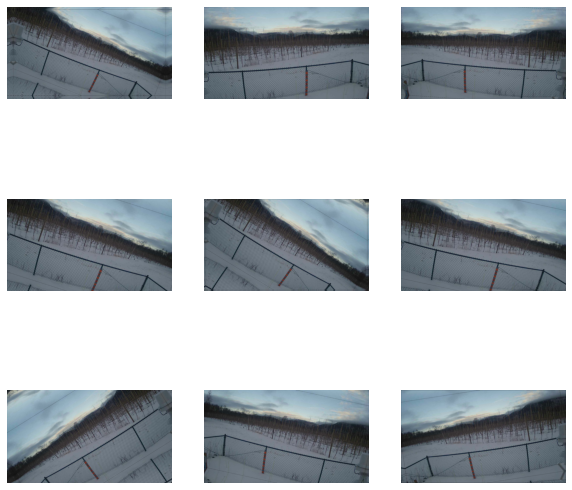

In [26]:
#viz augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
#Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 720, 1280, 3)      0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 720, 1280, 3)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 720, 1280, 16)     448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 360, 640, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 360, 640, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 180, 320, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 320, 64)     

In [29]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
34/34 [==============================] - 10s 299ms/step - loss: 5.8526 - accuracy: 0.3882 - val_loss: 1.1360 - val_accuracy: 0.5880
Epoch 2/25
34/34 [==============================] - 8s 233ms/step - loss: 0.9898 - accuracy: 0.6062 - val_loss: 0.8637 - val_accuracy: 0.6629
Epoch 3/25
34/34 [==============================] - 9s 276ms/step - loss: 0.8361 - accuracy: 0.6632 - val_loss: 0.8597 - val_accuracy: 0.7041
Epoch 4/25
34/34 [==============================] - 11s 326ms/step - loss: 0.8908 - accuracy: 0.6445 - val_loss: 0.7412 - val_accuracy: 0.7715
Epoch 5/25
34/34 [==============================] - 11s 310ms/step - loss: 0.7166 - accuracy: 0.7109 - val_loss: 0.8087 - val_accuracy: 0.7079
Epoch 6/25
34/34 [==============================] - 8s 230ms/step - loss: 0.6759 - accuracy: 0.7456 - val_loss: 0.7390 - val_accuracy: 0.7378
Epoch 7/25
34/34 [==============================] - 8s 230ms/step - loss: 0.5912 - accuracy: 0.7774 - val_loss: 0.5906 - val_accuracy: 0.8202
Epo

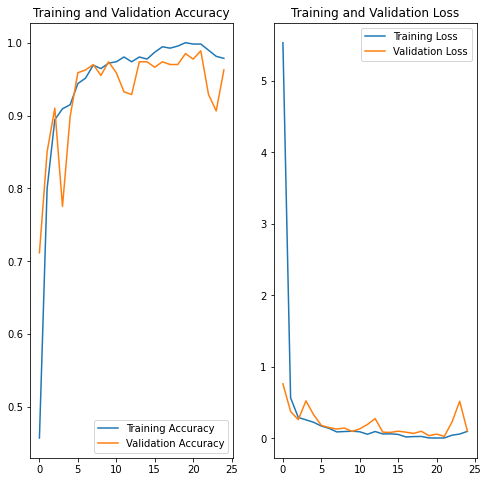

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[ 2.1049407  2.0030262 -3.1161888  2.5015752 -2.3226466  9.00036
  -6.2659035]]
This image most likely belongs to scattered with a 99.66 percent confidence.


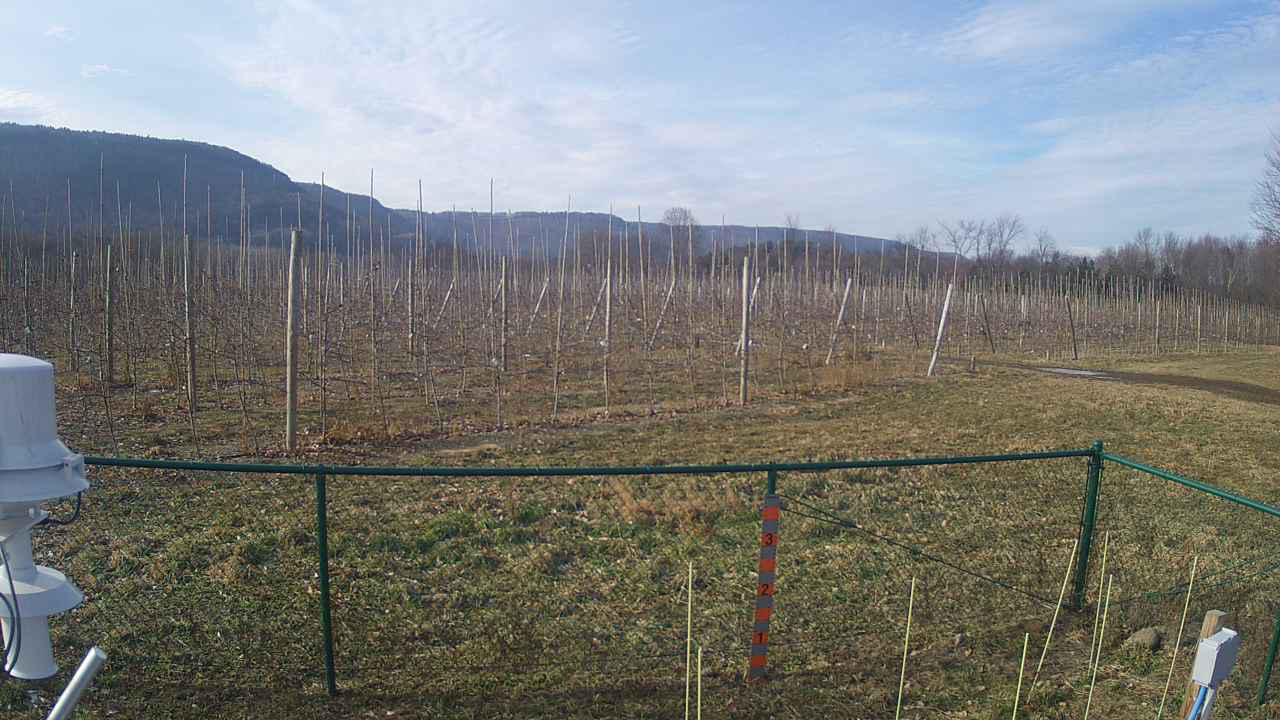

In [27]:
#overcast 20191030T161529_VOOR

#rain 20161013T164513_YORK.jpg_sliding_window.jpg

#partly 20191112T183029_VOOR

#clear 20190511T122529_VOOR
#clear 20191008T165026_BURT
#clear 20160420T221001_DELE
new_img_path = '/home/mesonet/cam_photos/2018/12/20/VOOR/20181220T175030_VOOR.jpg'
#new_img_path = '/home/arnold/raindrop-detection-cnn/mesonet/20161013T164513_YORK.jpg_sliding_window.jpg'

img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)

['clear', 'few', 'night', 'overcast', 'rain', 'scattered', 'snow']
[0 3 6 0 6 3 3 3 6 6 0 0 6 3 3 3 0 3 0 3 4 0 3 0 3 3 3 4 3 3 0 3 3 4 3 6 3
 3 6 6 6 5 3 6 0 3 3 3 3 0 0 4 3 0 0 0 3 4 3 0 5 6 3 3 0 3 3 0 6 0 0 6 6 0
 6 6 6 4 3 3 4 0 0 3 6 0 3 0 3 3 6 3 6 6 3 3 3 3 3 5 0 0 0 3 3 6 0 3 3 6 0
 5 3 6 3 3 3 5 5 6 3 3 5 0 6 3 0 0 6 0 0 5 3 3 3 3 6 3 3 0 3 3 5 6 3 5 3 0
 4 0 3 6 3 0 5 3 3 0 3 3 6 3 6 3 3 6 0 6 6 3 5 6 4 3 3 3 6 0 6 4 0 6 3 3 3
 5 0 0 6 0 3 3 5 3 3 6 0 4 3 0 0 6 5 3 0 6 3 0 3 6 3 5 6 6 3 3 6 3 3]
This image most likely belongs to clear with a 97.74 percent confidence.


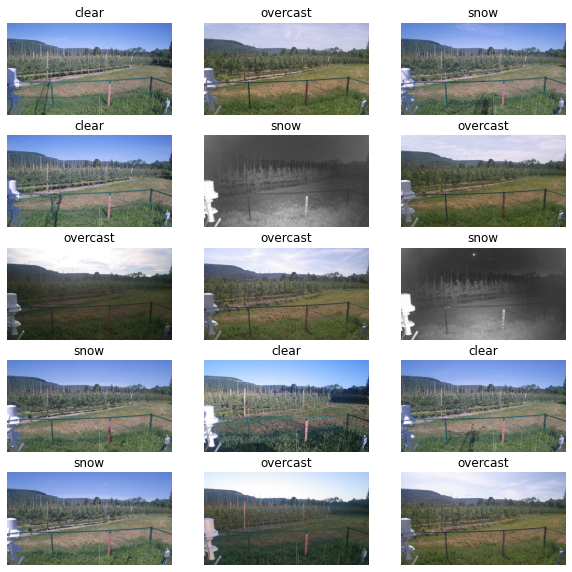

In [86]:
folder_path = '/home/mesonet/cam_photos/2018/06/17/VOOR'
from keras.preprocessing import image

# load all images into a list
paths = []
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    paths.append(img)
    img = image.load_img(img, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
#print(paths)
# for i in paths:
#     PIL.Image.open(i)
#

classes = model.predict_classes(images, batch_size=32)
print(class_names)
print(classes)
predictions = model.predict(images)
score = tf.nn.softmax(predictions[0])
#print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
#print(paths[-1])
#PIL.Image.open(paths[-1])
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
#     predictions = model.predict(image[i])
#     score = tf.nn.softmax(predictions[0])
#     plt.title(class_names[np.argmax(score)], 100 * np.max(score))
    plt.title(class_names[classes[i]])
    plt.axis("off")

In [122]:
# print (class_names)
j=0
rain_imgs = []
plt.figure(figsize=(10, 9))
for k,i in enumerate(classes):
#     print(k,i)
    if i==4:
        j += 1
        rain_imgs.append(images[k])
#         plt.subplot(3,4,i+1)
#         plt.imshow(images[k].astype("uint8"))
#         plt.title(class_names[i])
#         plt.axis('off')
#         print(j)
#         print(class_names[i])
#         plt.imshow(images[i].astype("uint8"))
# print(rain_imgs)

    

<Figure size 720x648 with 0 Axes>

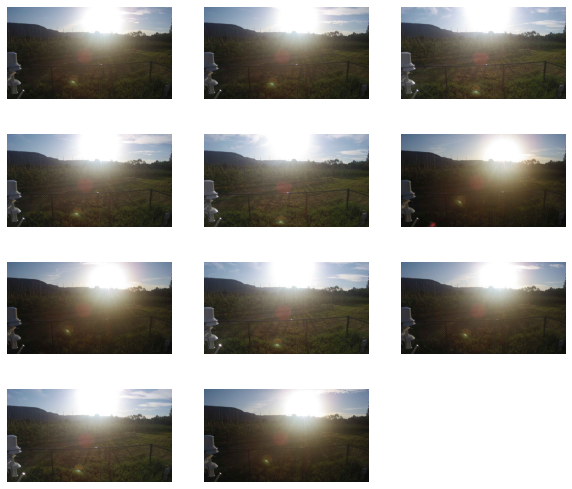

In [138]:
plt.figure(figsize=(10, 9))
# print((rain_imgs[1]))
plt.imshow(rain_imgs[1].astype("uint8"))
plt.imshow(rain_imgs[2].astype("uint8"))

for i in range(11):
    plt.subplot(4,3,i+1)
    plt.imshow(rain_imgs[i].astype("uint8"))
#     plt.title(class_names[i])
    plt.axis('off')

In [72]:
tf_model_predictions = model.predict(images)


In [88]:
print(tf_model_predictions.shape) #“Prediction results shape:”, (219, 7)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
# predicted_labels = class_names[predicted_ids]
print(predicted_ids)

(219, 7)
[0 3 6 0 6 3 3 3 6 6 0 0 6 3 3 3 0 3 0 3 4 0 3 0 3 3 3 4 3 3 0 3 3 4 3 6 3
 3 6 6 6 5 3 6 0 3 3 3 3 0 0 4 3 0 0 0 3 4 3 0 5 6 3 3 0 3 3 0 6 0 0 6 6 0
 6 6 6 4 3 3 4 0 0 3 6 0 3 0 3 3 6 3 6 6 3 3 3 3 3 5 0 0 0 3 3 6 0 3 3 6 0
 5 3 6 3 3 3 5 5 6 3 3 5 0 6 3 0 0 6 0 0 5 3 3 3 3 6 3 3 0 3 3 5 6 3 5 3 0
 4 0 3 6 3 0 5 3 3 0 3 3 6 3 6 3 3 6 0 6 6 3 5 6 4 3 3 3 6 0 6 4 0 6 3 3 3
 5 0 0 6 0 3 3 5 3 3 6 0 4 3 0 0 6 5 3 0 6 3 0 3 6 3 5 6 6 3 3 6 3 3]


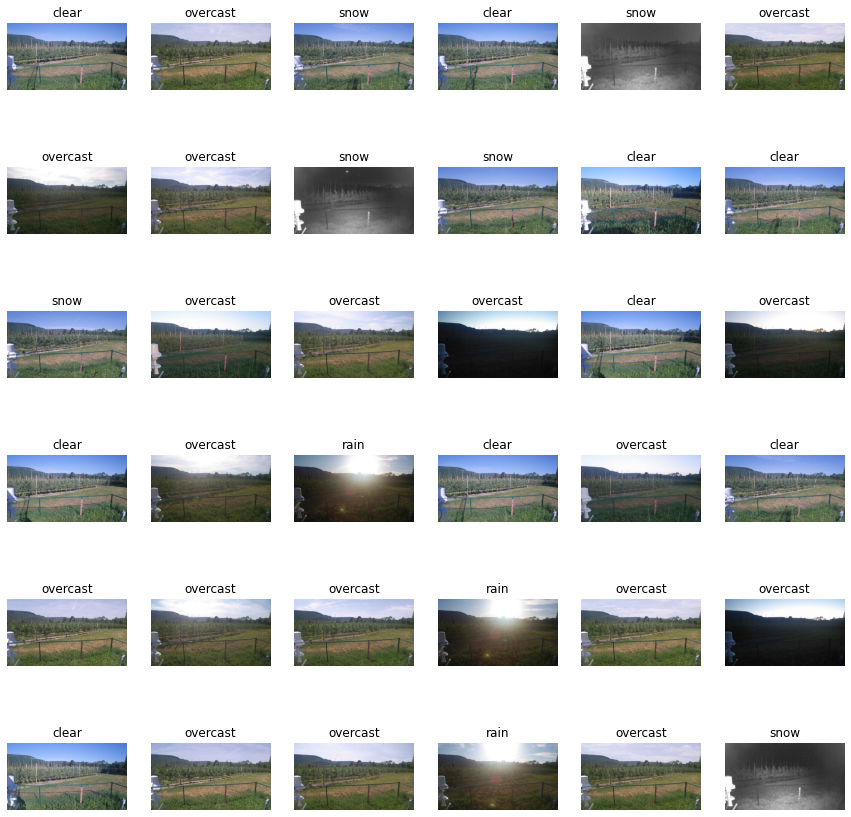

In [140]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(36): #predicted_labels
    plt.subplot(6,6,n+1)
    plt.imshow(images[n].astype("uint8"))
#     color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(class_names[predicted_ids[n]]) #predicted_labels
    plt.axis('off')
#     _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")